In [104]:
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import statistics
import time
import random

In [105]:
%%file ASMBlimite.asm
global calculolimiteASMB
calculolimiteASMB:
;calculoASM=calculolimiteASMB(n);
; xmm0 →return, rdi→n
    xorpd xmm1,xmm1
    xorpd xmm2,xmm2
    xorpd xmm3,xmm3
    xor r8,r8
    xor r9, r9
    mov r8, 1
    mov r9,rdi
    cvtsi2sd xmm2,r9
    cvtsi2sd xmm1,r8
    cvtsi2sd xmm3,r8
    addsd xmm1,xmm2; ← xmm1=n+1
    divsd xmm1,xmm2; ← xmm1/n = (1+n)/n
    ;movsd xmm2,xmm1; aqui almaceno el valor para ir multiplicandolo
    ; xmm1→ x 
    ; r9 → n or xmm2 → n
    mov rax,r9 ; dividiré lo que está en el rax, para tener el mod
    mov r8,2
    potenciadorBinario:
        xor rdx,rdx
        div r8; rax/r8
        cmp rdx,0 
        jne esimpar
        continuar:
        mulsd xmm1,xmm1
        cmp rax,0
    jg potenciadorBinario

fin:
    movsd xmm0,xmm3; aqui retorno el valor
ret

    esimpar:
        mulsd xmm3,xmm1
    jmp continuar


Overwriting ASMBlimite.asm


In [106]:
%%file limiteASMB.c
extern double calculolimiteASMB(int); 

Overwriting limiteASMB.c


In [107]:
! nasm -g -f elf64 ASMBlimite.asm -o calculoASM.o
! gcc -g -shared calculoASM.o  limiteASMB.c -o calculolimiteASMB.so

In [108]:
%%file limiteC.c
double calculolimiteCB(int n){
    double limite=1 ,x=(double)(1+n)/n;
    int aux=n;
    while(aux>0){
        if(!(aux%2==0))
            limite*=x;
        x*=x;
        aux= aux/2;
    }
    return limite;
}

Overwriting limiteC.c


In [109]:
! gcc -c -Wall -Werror -fpic limiteC.c
! gcc -shared limiteC.o -o calculoLimiteC.so

In [110]:
def ctypes_calculolimiteASMB():
    #indicar la ruta del a shared library 
    libfile='./calculolimiteASMB.so'
    #cargar la shared library
    lib=ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.calculolimiteASMB.argtypes=[ctypes.c_int]
    #tipo de dato que devuelve
    lib.calculolimiteASMB.restype=ctypes.c_double
    return lib.calculolimiteASMB

In [111]:
def ctypes_calculolimiteCB():
    #indicar la ruta del a shared library 
    libfile='./calculoLimiteC.so'
    #cargar la shared library
    lib=ctypes.CDLL(libfile)
    #si quisiera poner double es np.float64
    lib.calculolimiteCB.argtypes=[ctypes.c_int]
    #tipo de dato que devuelve
    lib.calculolimiteCB.restype=ctypes.c_double
    return lib.calculolimiteCB

In [112]:
# tam
calculolimiteASMB=ctypes_calculolimiteASMB()
calculolimiteCB=ctypes_calculolimiteCB()

In [113]:
calculolimiteASMB(5)==calculolimiteCB(5)

True

In [114]:
import statistics

def filtro_mediana(sign, ventana):
    signc = []
    tam = len(sign)
    offs = int((ventana-1)/2)
    for i in range(tam):
        inicio = i - offs if (i - offs > 0) else i
        fin = i + offs if (i + offs < tam) else tam
        signc.append(statistics.median(sign[inicio:fin]))
    return signc

In [116]:
# primero el caso más pequeño
veces = 40
tam = sizes[-1]
index = range(veces)
tcp = []
tasmp = []

for i in range(veces):
    # entradas
    xp = random.randrange(1,1000,1)
    
    # tiempo C
    t = time.time()
    rc = calculolimiteCB(xp)
    tcp.append(time.time() - t)
    
    # tiempo ASM
    t = time.time()
    rasm = calculolimiteASMB(xp)
    tasmp.append(time.time() - t)

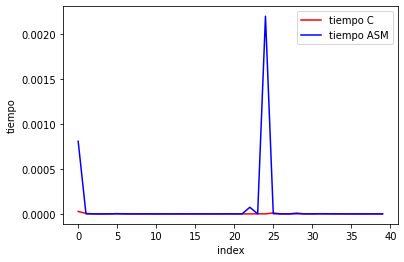

In [117]:
plt.plot(index, tcp, 'r-', label='tiempo C')
plt.plot(index, tasmp, 'b-', label='tiempo ASM')
plt.xlabel('index')
plt.ylabel('tiempo')
plt.legend()
plt.show()

In [118]:
%%file funcionmain.c
#include <stdio.h>
#include<math.h>
#include<stdlib.h>

//aqui declaro las funciones

double calculolimiteCB(int);
extern double calculolimiteASMB(int); 


int main(int argc, char **argv){
    double calculoC,calculoASM,d=0.5;
    int i, n, cantpar, r2,a=4;
    n = (int)atoi(argv[1]);
    calculoC=calculolimiteCB(n);
    printf("El limite en C  es %lf \n",calculoC); 
    calculoASM=calculolimiteASMB(n);
    printf("El limite en ASM es %lf \n",calculoASM);
    return 0;
}
double calculolimiteCB(int n){
    double resultado,base; 
    base=1+ (1/(double)n);
    resultado=pow(base,n);
    return resultado;
}

Overwriting funcionmain.c


In [119]:
! gcc -g calculoASM.o  funcionmain.c -o limite -lm
! ./limite 5

El limite en C  es 2.488320 
El limite en ASM es 2.488320 


In [120]:
%%file depurador.gdb 
set logging file reporte.txt
set print pretty on
set logging on
set pagination off
file limite
define hook-echo
echo <------
end
define hookpost-echo
echo ------>\n
end
set args 5
b potenciadorBinario
b continuar
b fin

run
echo REGISTROS 1.0
info r rax r9

set $cont = $rax 


while ($cont!=0)
    
    p $xmm1.v2_double
    p $rdx 
    c
    set $cont= $rax
    
end
c
nexti 
p $xmm0.v2_double
 
quit

Overwriting depurador.gdb


In [121]:
! gdb -x depurador.gdb

GNU gdb (Ubuntu 9.1-0ubuntu1) 9.1
Copyright (C) 2020 Free Software Foundation, Inc.
License GPLv3+: GNU GPL version 3 or later <http://gnu.org/licenses/gpl.html>
This is free software: you are free to change and redistribute it.
There is NO WARRANTY, to the extent permitted by law.
Type "show copying" and "show warranty" for details.
This GDB was configured as "x86_64-linux-gnu".
Type "show configuration" for configuration details.
For bug reporting instructions, please see:
<http://www.gnu.org/software/gdb/bugs/>.
Find the GDB manual and other documentation resources online at:
    <http://www.gnu.org/software/gdb/documentation/>.

For help, type "help".
Type "apropos word" to search for commands related to "word".
Breakpoint 1 at 0x119b
Breakpoint 2 at 0x11a7
Breakpoint 3 at 0x11b1
El limite en C  es 2.488320 

Breakpoint 1, 0x000055555555519b in potenciadorBinario ()
<------REGISTROS 1.0------>
rax            0x5                 5
r9             0x5                 5
$1 = {1.2, 0}
$

In [141]:
# modulo para medir el tiempo
import time

# tamaños de los arreglos
valores=np.random.randint(100, 1000, (11,1))

# tiempos de la suma de arreglos de floats64 en C
tc = np.zeros((len(valores),1),dtype=np.float32)#retorna un arreglo vacío
#            filas=4,colum=1, tipo
# tiempos de la suma de arreglos de floats64 en ASM
tasm = np.zeros((len(valores),1),dtype=np.float32)


In [142]:
veces = 40

index = range(veces)
tcp = []
tasmp = []
for i, valor in enumerate(valores):
    tci = []
    tasmi = []
    for j in range(veces):
    # entradas
        xp = random.randrange(1,1000,1)
    
    # tiempo C
        t = time.time()
        rc = calculolimiteCB(xp)
        tci.append(time.time() - t)
    
        # tiempo ASM
        t = time.time()
        rasm = calculolimiteASMB(xp)
        tasmi.append(time.time() - t)
    tc[i] = statistics.mean(filtro_mediana(tci,7))
    tasm[i] = statistics.mean(filtro_mediana(tasmi,7))     

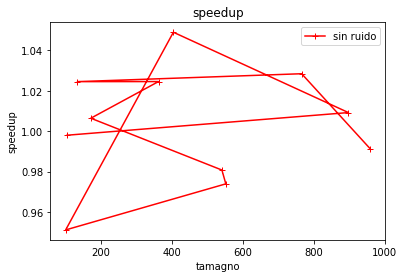

In [143]:
np.seterr(divide='ignore', invalid='ignore')
plt.plot(valores, tc/tasm, 'r-+',label='sin ruido')
plt.title('speedup')
plt.xlabel('tamagno')
plt.ylabel('speedup')
plt.legend()
plt.show()